In [1]:
from transformers import BertTokenizer, BertModel, AlbertTokenizerFast, AlbertModel
import torch
import torch.nn.functional as F
import re
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the input string
reactions_data = """
1 [Blood-Lymph].CTLA4_mabB <-> Lymph_Node.CTLA4_mab
2 [Blood-Lymph].CTLA4_mabB <-> Peripheral.CTLA4_mabP_leaky
3 [Blood-Lymph].CTLA4_mabB <-> Peripheral.CTLA4_mabP_tight
4 [Blood-Lymph].CTLA4_mabB <-> Tumor.CTLA4_mabt
5 [Blood-Lymph].CTLA4_mabB -> null
6 [Blood-Lymph].Effector_T_TB -> [Blood-Lymph].Effector_T_TB + [Blood-Lymph].Effector_TB
7 [Blood-Lymph].Effector_TB -> Liv_Spln_GI.EffT_GI_f_Vasc
8 [Blood-Lymph].Effector_TB -> Liv_Spln_GI.EffT_Liver_f_Vasc
9 [Blood-Lymph].Effector_TB -> Liv_Spln_GI.EffT_Spleen_f_Vasc
10 [Blood-Lymph].Effector_TB -> Lymph_Node.EffT_LN_f_Vasc
11 [Blood-Lymph].Effector_TB -> null
12 [Blood-Lymph].Effector_TB -> Peripheral.EffT_P_f_Vasc
13 [Blood-Lymph].Effector_TB -> Tumor.EffT_f_Vasc
14 [Blood-Lymph].PD1_mabb <-> Lymph_Node.PD1_mab
15 [Blood-Lymph].PD1_mabb <-> Peripheral.PD1_mabP_leaky
16 [Blood-Lymph].PD1_mabb <-> Peripheral.PD1_mabP_tight
17 [Blood-Lymph].PD1_mabb <-> Tumor.PD1_mabt
18 [Blood-Lymph].PD1_mabb -> null
19 [Blood-Lymph].PDL1_mabb <-> Lymph_Node.PDL1_mab
20 [Blood-Lymph].PDL1_mabb <-> Peripheral.PDL1_mabP_leaky
21 [Blood-Lymph].PDL1_mabb <-> Peripheral.PDL1_mabP_tight
22 [Blood-Lymph].PDL1_mabb <-> Tumor.PDL1_mabt
23 [Blood-Lymph].PDL1_mabb -> null
24 [Blood-Lymph].PDL1_mabb -> null
25 Liv_Spln_GI.EffT_GI_f_Vasc -> Liv_Spln_GI.EffT_Liver_f_Vasc
26 Liv_Spln_GI.EffT_GI_f_Vasc -> null
27 Liv_Spln_GI.EffT_Liver_AR_Vasc -> Liv_Spln_GI.EffT_LiverEx
28 Liv_Spln_GI.EffT_Liver_AR_Vasc -> null
29 Liv_Spln_GI.EffT_Liver_b_Vasc -> Liv_Spln_GI.EffT_Liver_AR_Vasc
30 Liv_Spln_GI.EffT_Liver_b_Vasc -> Liv_Spln_GI.EffT_Liver_f_Vasc
31 Liv_Spln_GI.EffT_Liver_b_Vasc -> null
32 Liv_Spln_GI.EffT_Liver_f_Vasc -> Lungs.EffT_f_LungsVasc
33 Liv_Spln_GI.EffT_Liver_f_Vasc -> null
34 Liv_Spln_GI.EffT_LiverEx -> Lymph_Node.EffT_LN_ExRec
35 Liv_Spln_GI.EffT_LiverEx -> null
36 Liv_Spln_GI.EffT_Spleen_AR_Vasc -> Liv_Spln_GI.EffT_SpleenEx
37 Liv_Spln_GI.EffT_Spleen_AR_Vasc -> null
38 Liv_Spln_GI.EffT_Spleen_b_Vasc -> Liv_Spln_GI.EffT_Spleen_AR_Vasc
39 Liv_Spln_GI.EffT_Spleen_b_Vasc -> Liv_Spln_GI.EffT_Spleen_f_Vasc
40 Liv_Spln_GI.EffT_Spleen_b_Vasc -> null
41 Liv_Spln_GI.EffT_Spleen_f_Vasc + Liv_Spln_GI.Spleen_Free_Sites -> Liv_Spln_GI.EffT_Spleen_b_Vasc + Liv_Spln_GI.Spleen_Free_Sites
42 Liv_Spln_GI.EffT_Spleen_f_Vasc -> Liv_Spln_GI.EffT_Liver_f_Vasc
43 Liv_Spln_GI.EffT_Spleen_f_Vasc -> null
44 Liv_Spln_GI.EffT_SpleenEx -> Lymph_Node.EffT_LN_ExRec
45 Liv_Spln_GI.EffT_SpleenEx -> null
46 Liv_Spln_GI.Liver_Free_Sites + Liv_Spln_GI.EffT_Liver_f_Vasc -> Liv_Spln_GI.EffT_Liver_b_Vasc + Liv_Spln_GI.Liver_Free_Sites
47 Lungs.EffT_AR_LungsVasc -> Lungs.EffT_LungsEx
48 Lungs.EffT_AR_LungsVasc -> null
49 Lungs.EffT_AR_LungsVasc -> null
50 Lungs.EffT_f_LungsVasc + Lungs.Lung_Free_Sites -> Lungs.EffT_r_LungsVasc + Lungs.Lung_Free_Sites
51 Lungs.EffT_f_LungsVasc -> [Blood-Lymph].Effector_TB
52 Lungs.EffT_f_LungsVasc -> null
53 Lungs.EffT_LungsEx -> Lymph_Node.EffT_LN_ExRec
54 Lungs.EffT_LungsEx -> null
55 Lungs.EffT_r_LungsVasc -> Lungs.EffT_AR_LungsVasc
"""
reaction_rate_data = """1 Kpa_LNB*S_LNB*VL*f_LN_CTLA4*([Blood-Lymph].CTLA4_mabB/Vc_CTLA4-Lymph_Node.CTLA4_mab/VL)
2 0.67*Q_L*[Blood-Lymph].CTLA4_mabB*(1-Sigma1_CTLA4)/Vc_CTLA4 -
(Peripheral.CTLA4_mabP_leaky/(0.35*ISF*KP_CTLA4))*0.33*Q_L*(1-Sigma1_CTLA4)
3 0.33*Q_L*[Blood-Lymph].CTLA4_mabB*(1-Sigma2_CTLA4)/Vc_CTLA4-
(Peripheral.CTLA4_mabP_tight/(0.65*ISF*KP_CTLA4))*0.33*Q_L*(1-Sigma2_CTLA4)
4 Kpa_TB*S_TB*Vt_avg_const*[Blood-Lymph].CTLA4_mabB/Vc_PD1-
Kpa_TB*S_TB*Vt_avg_const*Tumor.CTLA4_mabt/(Vex_Tmr)
5 Cl_CTLA4*[Blood-Lymph].CTLA4_mabB
6 EffT_Migrate*[Blood-Lymph].Effector_T_TB
7 QC_GI*[Blood-Lymph].Effector_TB/Vc_Teff
8 (QC_Liver-QC_GI-QC_Spleen+LC_GI+LC_Spleen)*[Blood-Lymph].Effector_TB/Vc_Teff
9 QC_Spleen * [Blood-Lymph].Effector_TB/Vc_Teff
10 QC_LN*[Blood-Lymph].Effector_TB/Vc_Teff
11 EffT_Turnover*[Blood-Lymph].Effector_TB
12 QC_Periph*[Blood-Lymph].Effector_TB/Vc_Teff
13 QC_Tmr*TCytokineHoming*[Blood-Lymph].Effector_TB/Vc_Teff
14 Kpa_LNB*S_LNB*VL*f_LN_PD1*([Blood-Lymph].PD1_mabb/Vc_PD1-Lymph_Node.PD1_mab/VL)
15 0.67*Q_L*PD1_mabb*(1-Sigma1_PD1)/Vc_PD1-(Peripheral.PD1_mabP_leaky/(0.35*ISF*KP_PD1))*0.33*Q_L*(1-
Sigma1_PD1)
16 0.33*Q_L*[Blood-Lymph].PD1_mabb*(1-Sigma2_PD1)/Vc_PD1-
(Peripheral.PD1_mabP_tight/(0.65*ISF*KP_PD1))*0.33*Q_L*(1-Sigma2_PD1)
17 Kpa_TB*S_TB*Vt_avg_const*[Blood-Lymph].PD1_mabb/Vc_PD1-
Kpa_TB*S_TB*Vt_avg_const*Tumor.PD1_mabt/(Vex_Tmr)
18 (Cl_PD1/Vc_PD1)*[Blood-Lymph].PD1_mabb
19 Kpa_LNB*S_LNB*VL*f_LN_PD1*([Blood-Lymph].PDL1_mabb/Vc_PDL1-Lymph_Node.PDL1_mab/VL)
20 0.67*Q_L*PDL1_mabb*(1-Sigma1_PDL1)/Vc_PDL1-(Peripheral.PDL1_mabP_leaky/(0.35*ISF*KP_PDL1))*0.33*Q_L*(1-
Sigma1_PDL1)
21 0.33*Q_L*[Blood-Lymph].PDL1_mabb*(1-Sigma2_PDL1)/Vc_PDL1-
(Peripheral.PDL1_mabP_tight/(0.65*ISF*KP_PDL1))*0.33*Q_L*(1-Sigma2_PDL1)
22 Kpa_TB*S_TB*Vt_avg_const*[Blood-Lymph].PDL1_mabb/Vc_PDL1-
Kpa_TB*S_TB*Vt_avg_const*Tumor.PDL1_mabt/(Vex_Tmr)
23 (Cl_PDL1/Vc_PDL1)*[Blood-Lymph].PDL1_mabb
24 (Vm/Durvalumab_MW)*[Blood-Lymph].PDL1_mabb/(Km*Vc_PDL1/Durvalumab_MW+[Blood-Lymph].PDL1_mabb)
25 (QC_GI - LC_GI)*Liv_Spln_GI.EffT_GI_f_Vasc/Vv_GI
26 EffT_Turnover*Liv_Spln_GI.EffT_GI_f_Vasc
27 J_Liver*Liv_Spln_GI.EffT_Liver_AR_Vasc
28 EffT_Turnover*Liv_Spln_GI.EffT_Liver_AR_Vasc
29 AR_Liver*[Liv_Spln_GI].EffT_Liver_b_Vasc
30 kr_Periph*Liv_Spln_GI.EffT_Liver_b_Vasc
31 EffT_Turnover*Liv_Spln_GI.EffT_Liver_b_Vasc
32 (QC_Liver - LC_Liver)*Liv_Spln_GI.EffT_Liver_f_Vasc/Vv_Liver
33 EffT_Turnover*Liv_Spln_GI.EffT_Liver_f_Vasc
34 LC_Liver*Delta_Liver*Liv_Spln_GI.EffT_LiverEx/Vext_Liver
35 EffT_Turnover*Liv_Spln_GI.EffT_LiverEx
36 J_Spleen*Liv_Spln_GI.EffT_Spleen_AR_Vasc
37 EffT_Turnover*Liv_Spln_GI.EffT_Spleen_AR_Vasc
38 AR_Spleen*[Liv_Spln_GI].EffT_Spleen_b_Vasc
39 kr_Periph*Liv_Spln_GI.EffT_Spleen_b_Vasc
40 EffT_Turnover*Liv_Spln_GI.EffT_Spleen_b_Vasc
41 kf_Spleen*Liv_Spln_GI.Spleen_Free_Sites*[Liv_Spln_GI].EffT_Spleen_f_Vasc/Vv_Spleen
42 (QC_Spleen - LC_Spleen)*Liv_Spln_GI.EffT_Spleen_f_Vasc/Vv_Spleen
43 EffT_Turnover*Liv_Spln_GI.EffT_Spleen_f_Vasc
44 LC_Spleen*Delta_Spleen*Liv_Spln_GI.EffT_SpleenEx/Vext_Spleen
45 EffT_Turnover*Liv_Spln_GI.EffT_SpleenEx
46 kf_Liver*Liver_Free_Sites*[Liv_Spln_GI].EffT_Liver_f_Vasc/Vv_Liver
47 J_Lungs*Lungs.EffT_AR_LungsVasc
48 EffT_Turnover*Lungs.EffT_AR_LungsVasc
49 E_Lungs*Lungs.EffT_AR_LungsVasc
50 kf_Lungs*Lung_Free_Sites*Lungs.EffT_f_LungsVasc/Vv_Lungs
51 (QC_Lungs - LC_Lungs)*Lungs.EffT_f_LungsVasc/Vv_Lungs
52 EffT_Turnover*Lungs.EffT_f_LungsVasc
53 LC_Lungs*Delta_Lungs*Lungs.EffT_LungsEx/Vext_Lungs
54 EffT_Turnover*Lungs.EffT_LungsEx
55 AR_Lungs*Lungs.EffT_r_LungsVasc
"""

desc_data = """1 Distribution of Anti-CTLA-4 mAb between the central and lymph node compartments
2 Distribution of Anti-CTLA-4 mAb between the central and leaky tissues
3 Distribution of Anti-CTLA-4 mAb between the central and tight tissues
4 Distribution of Anti-CTLA-4 mAb between the central and tumor compartments
5 Clearance of Anti-CTLA-4 mAb from the central compartment
6 The generation of Effector T cells and their migration into the blood/plasma from the designated number of lymph nodes as a
multiple of that from a single lymph node
7 Trafficking of free Effector T cells from blood to GI vasculature
8 Trafficking of free Effector T cells from blood to Liver vasculature
9 Trafficking of free Effector T cells from blood to Spleen vasculature
10 Trafficking of free Effector T cells from blood to Lymph Node vasculature
11 The natural turnover of Effector T cells in the blood
12 Trafficking of free Effector T cells from blood to Peripheral (other tissues not directly accounted for) vasculature
13 Trafficking of free Effector T cells from blood to Tumor vasculature
14 Distribution of Anti-PD-1 mAb between the central and lymph node compartments
15 Distribution of Anti-PD-1 mAb between the central and leaky tissues
16 Distribution of Anti-PD-1 mAb between the central and tight tissues
17 Distribution of Anti-PD-1 mAb between the central and tumor compartments
18 Clearance of Anti-PD-1 mAb from the central compartment
19 Distribution of Anti-PD-L1 mAb between the central and lymph node compartments
20 Distribution of Anti-PD-L1 mAb between the central and leaky tissues
21 Distribution of Anti-PD-L1 mAb between the central and tight tissues
22 Distribution of Anti-PD-L1 mAb between the central and tumor compartments
23 Clearance of Anti-PD-L1 mAb from the central compartment
24 Saturation of Anti-PD-L1 mAb clearance from the central compartment
25 Trafficking of Effector T cells from GI to Liver vasculature
26 Turnover of free Effector T cells in the GI vasculature
27 Extravasation of arrested Effector T cells from the Liver vasculature
28 Turnover of arrested Effector T cells in the Liver vasculature
29 Arrest of bound Effector T cells in the Liver vasculature
30 Detachment of bound Effector T cells in the Liver vasculature
31 Turnover of bound Effector T cells in the liver vasculature
32 Trafficking of free Effector T cells from Liver to Lung vasculature
33 Turnover of free Effector T cells in the liver vasculature
34 Trafficking of free Effector T cells from Liver to lymph node extravascular space
35 Turnover of Effector T cells in the Liver extravascular space
36 Extravasation of arrested Effector T cells from the Spleen vasculature
37 Turnover of arrested Effector T cells in the Spleen vasculature
38 Arrest of bound Effector T cells in the Spleen vasculature
39 Detachment of bound Effector T cells in the Spleen vasculature
40 Turnover of bound Effector T cells in the Spleen vasculature
41 Binding or free Effector T cells to the Spleen vasculature
42 Trafficking of free Effector T cells from Spleen to Liver vasculature
43 Turnover of free Effector T cells in the Spleen vasculature
44 Trafficking of free Effector T cells from Spleen to lymph node extravascular space
45 Turnover of Effector T cells in the Spleen extravascular space
46 Binding or free Effector T cells to the Liver vasculature
47 Extravasation of arrested Effector T cells from the Lungs vasculature
48 Turnover of arrested Effector T cells in the Lungs vasculature
49 Depletion of arrested Effector T cells in the Lungs vasculature
50 Binding or free Effector T cells to the Lungs vasculature
51 Trafficking of free Effector T cells from Lungs to (arterial) Blood
52 Turnover of free Effector T cells in the Lungs vasculature
53 Trafficking of free Effector T cells from Lungs to lymph node extravascular space
54 Turnover of Effector T cells in the Lungs extravascular space
55 Arrest of bound Effector T cells in the Lungs vasculature
"""

In [3]:
def get_bert_tokenizer_and_model(tokenizer_path, model_path):
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    model = BertModel.from_pretrained(model_path)
    return tokenizer, model

def get_albert_tokenizer_and_model(tokenizer_path, model_path):
    tokenizer = AlbertTokenizerFast.from_pretrained(tokenizer_path)
    model = AlbertModel.from_pretrained(model_path)
    return tokenizer, model

In [4]:
def get_embedding(tokenizer, model, text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

    with torch.no_grad():  # Turn off gradient tracking for faster inference
        outputs = model(**inputs)

    # The embeddings are in `outputs.last_hidden_state`
    # `outputs.last_hidden_state` is a tensor of shape [batch_size, sequence_length, hidden_size]
    embeddings = outputs.last_hidden_state
    
    # If you want to get the embedding for the [CLS] token (which is often used as a sentence-level representation):
    return embeddings#[:, 0, :]  # [CLS] token is the first token


In [5]:
math_albert_path = "AnReu/albert-for-arqmath-3"
desc_bert_path = "bert-base-uncased"

In [6]:
mtokenizer, mmodel = get_albert_tokenizer_and_model(math_albert_path, math_albert_path)
dtokenizer, dmodel = get_bert_tokenizer_and_model(desc_bert_path, desc_bert_path)

Some weights of the model checkpoint at AnReu/albert-for-arqmath-3 were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
reactions = ["[Blood-Lymph].CTLA4_mabB <-> Lymph_Node.CTLA4_mab", "[Blood-Lymph].CTLA4_mabB <-> Peripheral.CTLA4_mabP_leaky"]

In [8]:
print(mtokenizer.tokenize(reactions[0]), dtokenizer.tokenize(reactions[0]))

['[', '▁blood', '-', '▁lymph', ']', '▁', '.', 'ct', 'la', '4', '_', '▁ma', 'bb', '<', '-', '>', '▁lymph', '_', '▁node', '.', 'ct', 'la', '4', '_', '▁mab'] ['[', 'blood', '-', 'l', '##ym', '##ph', ']', '.', 'ct', '##la', '##4', '_', 'mab', '##b', '<', '-', '>', 'l', '##ym', '##ph', '_', 'node', '.', 'ct', '##la', '##4', '_', 'mab']


In [9]:
def parse_data(text):
    lines = text.strip().split('\n')
    i = 1
    data = {1:''}
    for line in lines:
        split_line = line.split(" ",1)
        if (len(split_line)==1) or (not split_line[0].isdigit()) or (int(split_line[0]) != i):
            data[i-1] = data[i-1] + line
        else:
            data[i] = split_line[1]
            i+=1
    return data

In [10]:
def get_equations(reactions,reaction_rates):
    equations = {}
    for reaction_id in reactions.keys():
        reaction = reactions[reaction_id]
        reaction_rate = reaction_rates[reaction_id]
        neg, delim ,pos =re.split(r'(<->|->|<-)', reaction, maxsplit=1)
        all_terms = ["-" + term for term in neg.split("+")]
        all_terms.extend(pos.split("+"))
        all_terms.append(reaction_rate)
        equations[reaction_id] = (" = ".join(all_terms)).replace(" null =","")
    return equations

In [11]:
reaction_rates = parse_data(reaction_rate_data)
reactions = parse_data(reactions_data)
descriptions = parse_data(desc_data)

In [12]:
equations = get_equations(reactions, reaction_rates)

In [13]:
import pandas as pd
df1 = pd.DataFrame.from_dict(equations, orient='index', columns=['ode'])
df2 = pd.DataFrame.from_dict(descriptions, orient='index', columns=['desc'])
table = pd.concat([df1, df2], axis=1)
print(table.head())

                                                 ode  \
1  -[Blood-Lymph].CTLA4_mabB  =  Lymph_Node.CTLA4...   
2  -[Blood-Lymph].CTLA4_mabB  =  Peripheral.CTLA4...   
3  -[Blood-Lymph].CTLA4_mabB  =  Peripheral.CTLA4...   
4  -[Blood-Lymph].CTLA4_mabB  =  Tumor.CTLA4_mabt...   
5  -[Blood-Lymph].CTLA4_mabB  =  Cl_CTLA4*[Blood-...   

                                                desc  
1  Distribution of Anti-CTLA-4 mAb between the ce...  
2  Distribution of Anti-CTLA-4 mAb between the ce...  
3  Distribution of Anti-CTLA-4 mAb between the ce...  
4  Distribution of Anti-CTLA-4 mAb between the ce...  
5  Clearance of Anti-CTLA-4 mAb from the central ...  


In [14]:
descriptions

{1: 'Distribution of Anti-CTLA-4 mAb between the central and lymph node compartments',
 2: 'Distribution of Anti-CTLA-4 mAb between the central and leaky tissues',
 3: 'Distribution of Anti-CTLA-4 mAb between the central and tight tissues',
 4: 'Distribution of Anti-CTLA-4 mAb between the central and tumor compartments',
 5: 'Clearance of Anti-CTLA-4 mAb from the central compartment',
 6: 'The generation of Effector T cells and their migration into the blood/plasma from the designated number of lymph nodes as amultiple of that from a single lymph node',
 7: 'Trafficking of free Effector T cells from blood to GI vasculature',
 8: 'Trafficking of free Effector T cells from blood to Liver vasculature',
 9: 'Trafficking of free Effector T cells from blood to Spleen vasculature',
 10: 'Trafficking of free Effector T cells from blood to Lymph Node vasculature',
 11: 'The natural turnover of Effector T cells in the blood',
 12: 'Trafficking of free Effector T cells from blood to Peripheral (o

In [15]:
equations

{1: '-[Blood-Lymph].CTLA4_mabB  =  Lymph_Node.CTLA4_mab = Kpa_LNB*S_LNB*VL*f_LN_CTLA4*([Blood-Lymph].CTLA4_mabB/Vc_CTLA4-Lymph_Node.CTLA4_mab/VL)',
 2: '-[Blood-Lymph].CTLA4_mabB  =  Peripheral.CTLA4_mabP_leaky = 0.67*Q_L*[Blood-Lymph].CTLA4_mabB*(1-Sigma1_CTLA4)/Vc_CTLA4 -(Peripheral.CTLA4_mabP_leaky/(0.35*ISF*KP_CTLA4))*0.33*Q_L*(1-Sigma1_CTLA4)',
 3: '-[Blood-Lymph].CTLA4_mabB  =  Peripheral.CTLA4_mabP_tight = 0.33*Q_L*[Blood-Lymph].CTLA4_mabB*(1-Sigma2_CTLA4)/Vc_CTLA4-(Peripheral.CTLA4_mabP_tight/(0.65*ISF*KP_CTLA4))*0.33*Q_L*(1-Sigma2_CTLA4)',
 4: '-[Blood-Lymph].CTLA4_mabB  =  Tumor.CTLA4_mabt = Kpa_TB*S_TB*Vt_avg_const*[Blood-Lymph].CTLA4_mabB/Vc_PD1-Kpa_TB*S_TB*Vt_avg_const*Tumor.CTLA4_mabt/(Vex_Tmr)',
 5: '-[Blood-Lymph].CTLA4_mabB  =  Cl_CTLA4*[Blood-Lymph].CTLA4_mabB',
 6: '-[Blood-Lymph].Effector_T_TB  =  [Blood-Lymph].Effector_T_TB  =  [Blood-Lymph].Effector_TB = EffT_Migrate*[Blood-Lymph].Effector_T_TB',
 7: '-[Blood-Lymph].Effector_TB  =  Liv_Spln_GI.EffT_GI_f_Vasc = QC_

In [16]:
eq_embs =torch.cat([get_embedding(mtokenizer, mmodel, equation)[:,:2,:].view(1,-1) for equation in equations.values()])
desc_embs =torch.cat([get_embedding(dtokenizer, dmodel, desc)[:,:2,:].view(1,-1) for desc in descriptions.values()])

In [17]:
def get_similarity_matrix(embs):
    A = torch.zeros((len(embs), len(embs)))
    for i in range(len(embs)):
        for j in range(len(embs)):
            A[i,j] = F.cosine_similarity(embs[i], embs[j])
    return A

In [18]:
eq_sim = cosine_similarity(eq_embs,eq_embs)
desc_sim = cosine_similarity(desc_embs, desc_embs)

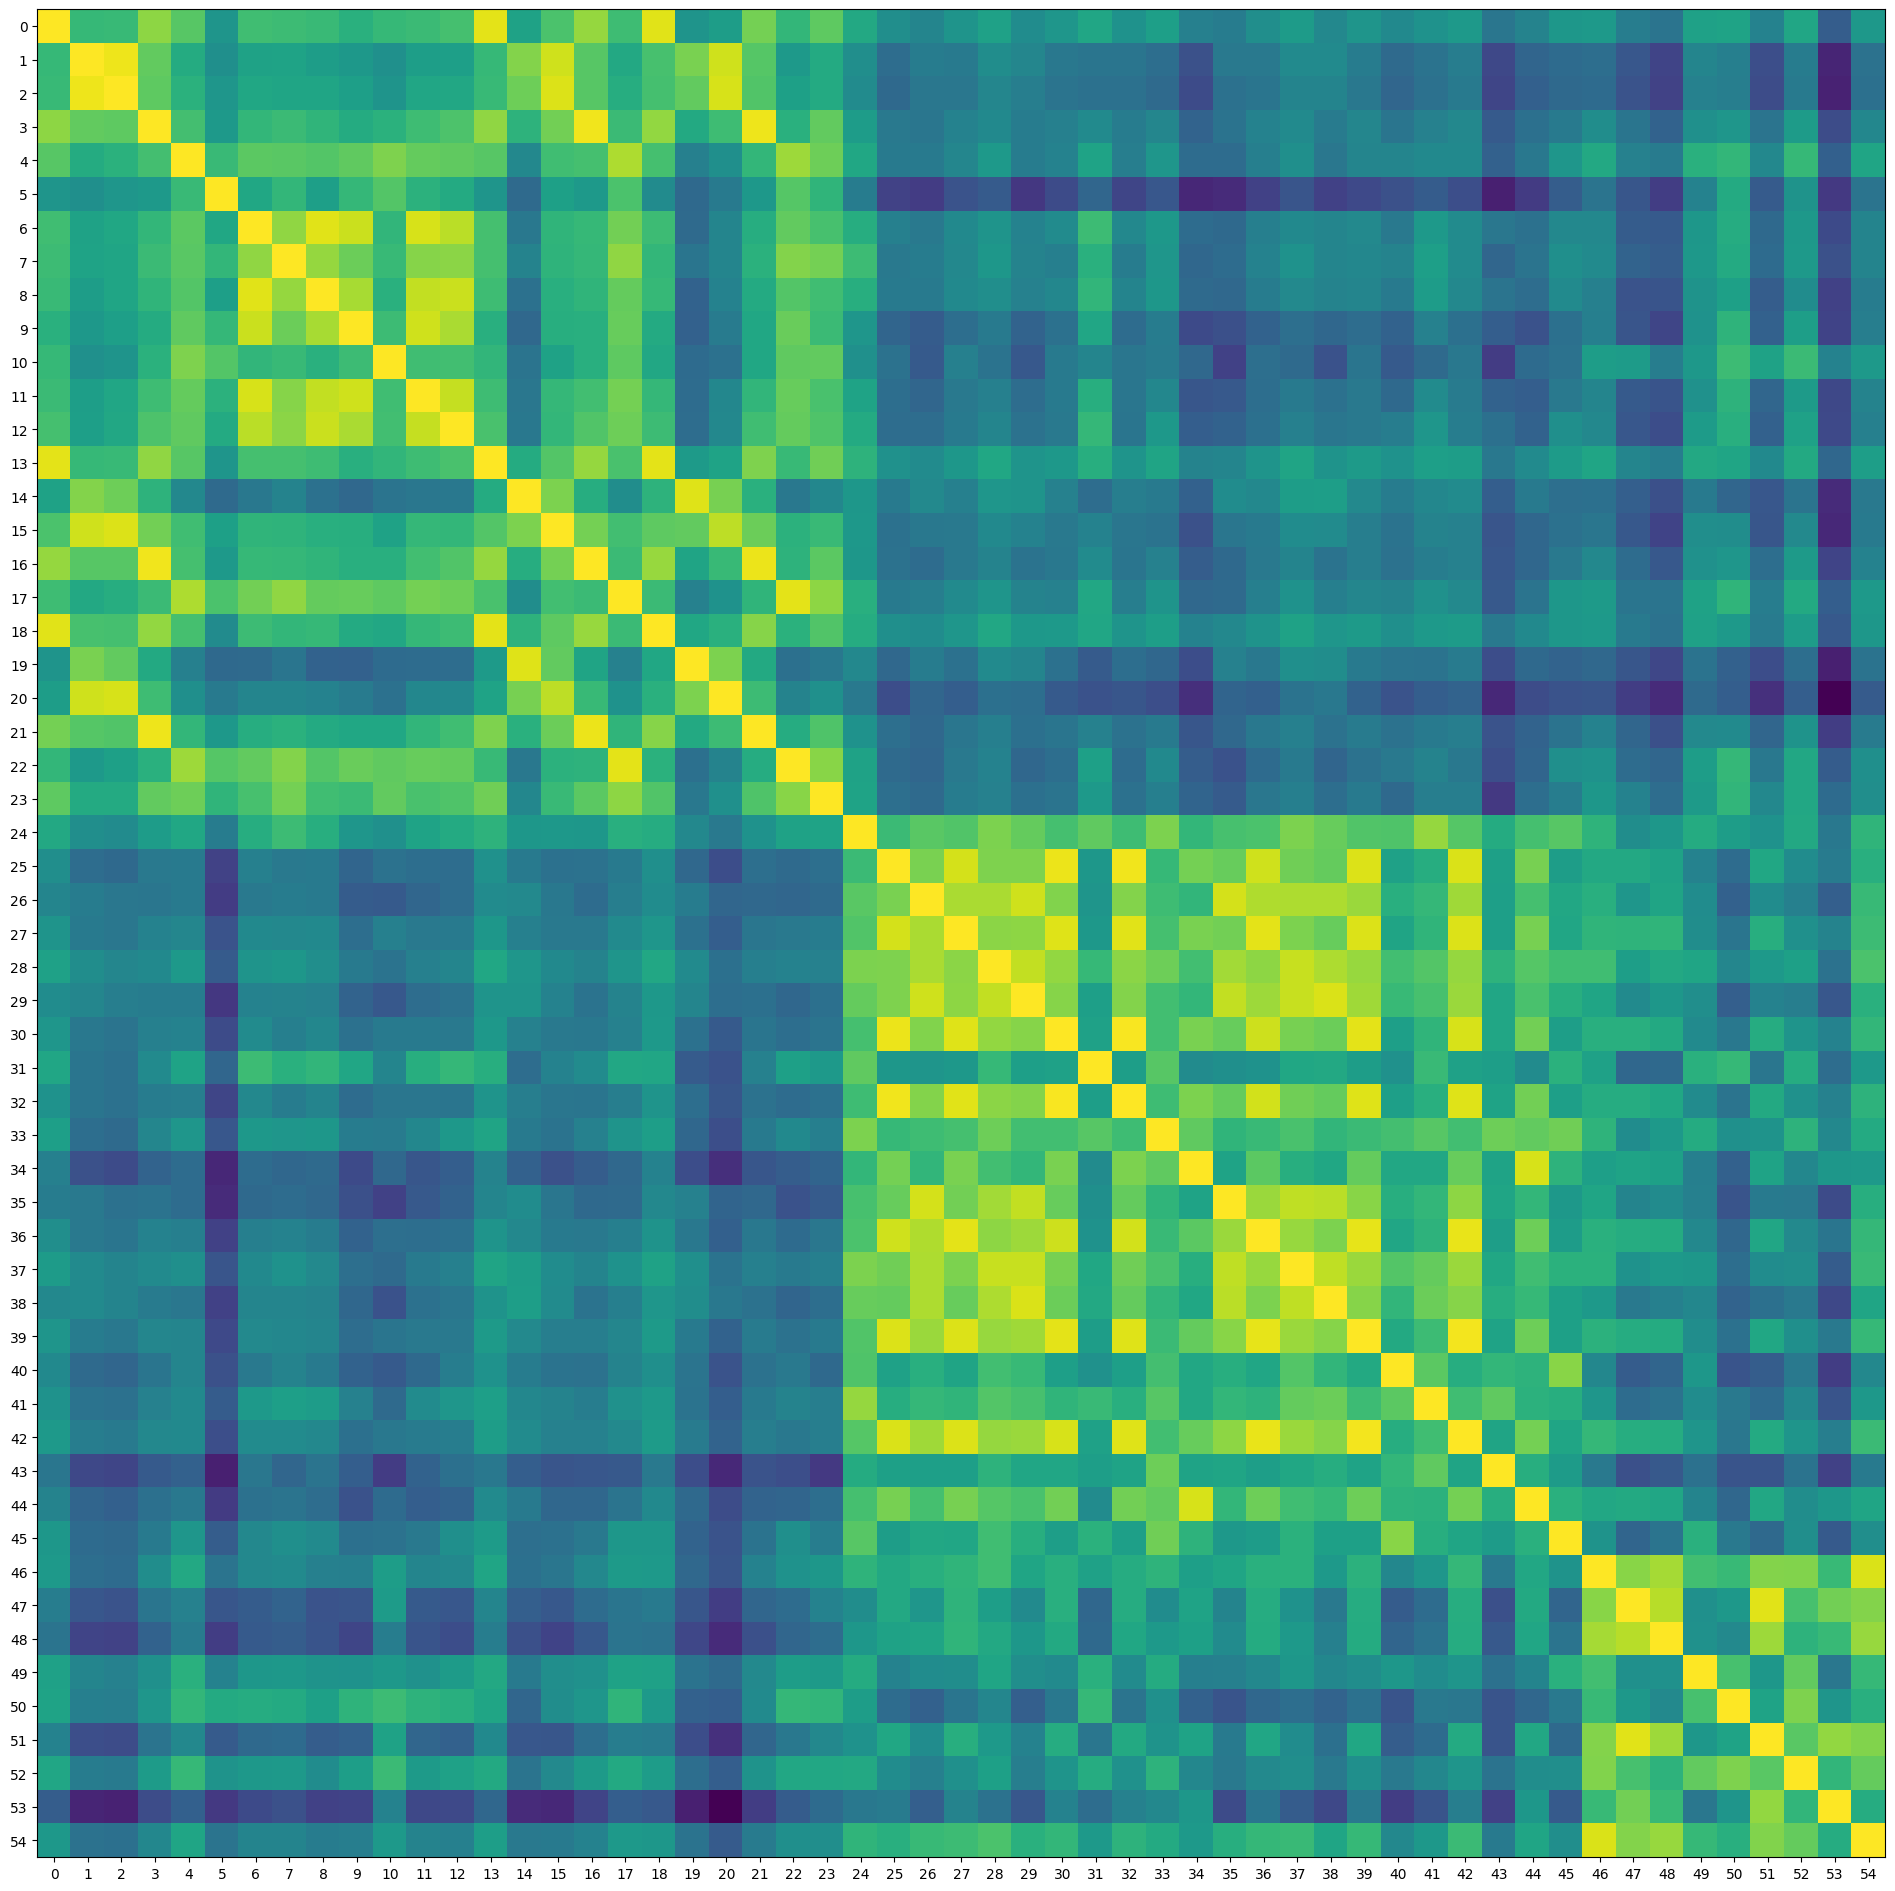

In [19]:
plt.figure(figsize=(24,24))
plt.xticks(range(eq_sim.shape[0]))
plt.yticks(range(eq_sim.shape[0]))
plt.imshow(eq_sim)

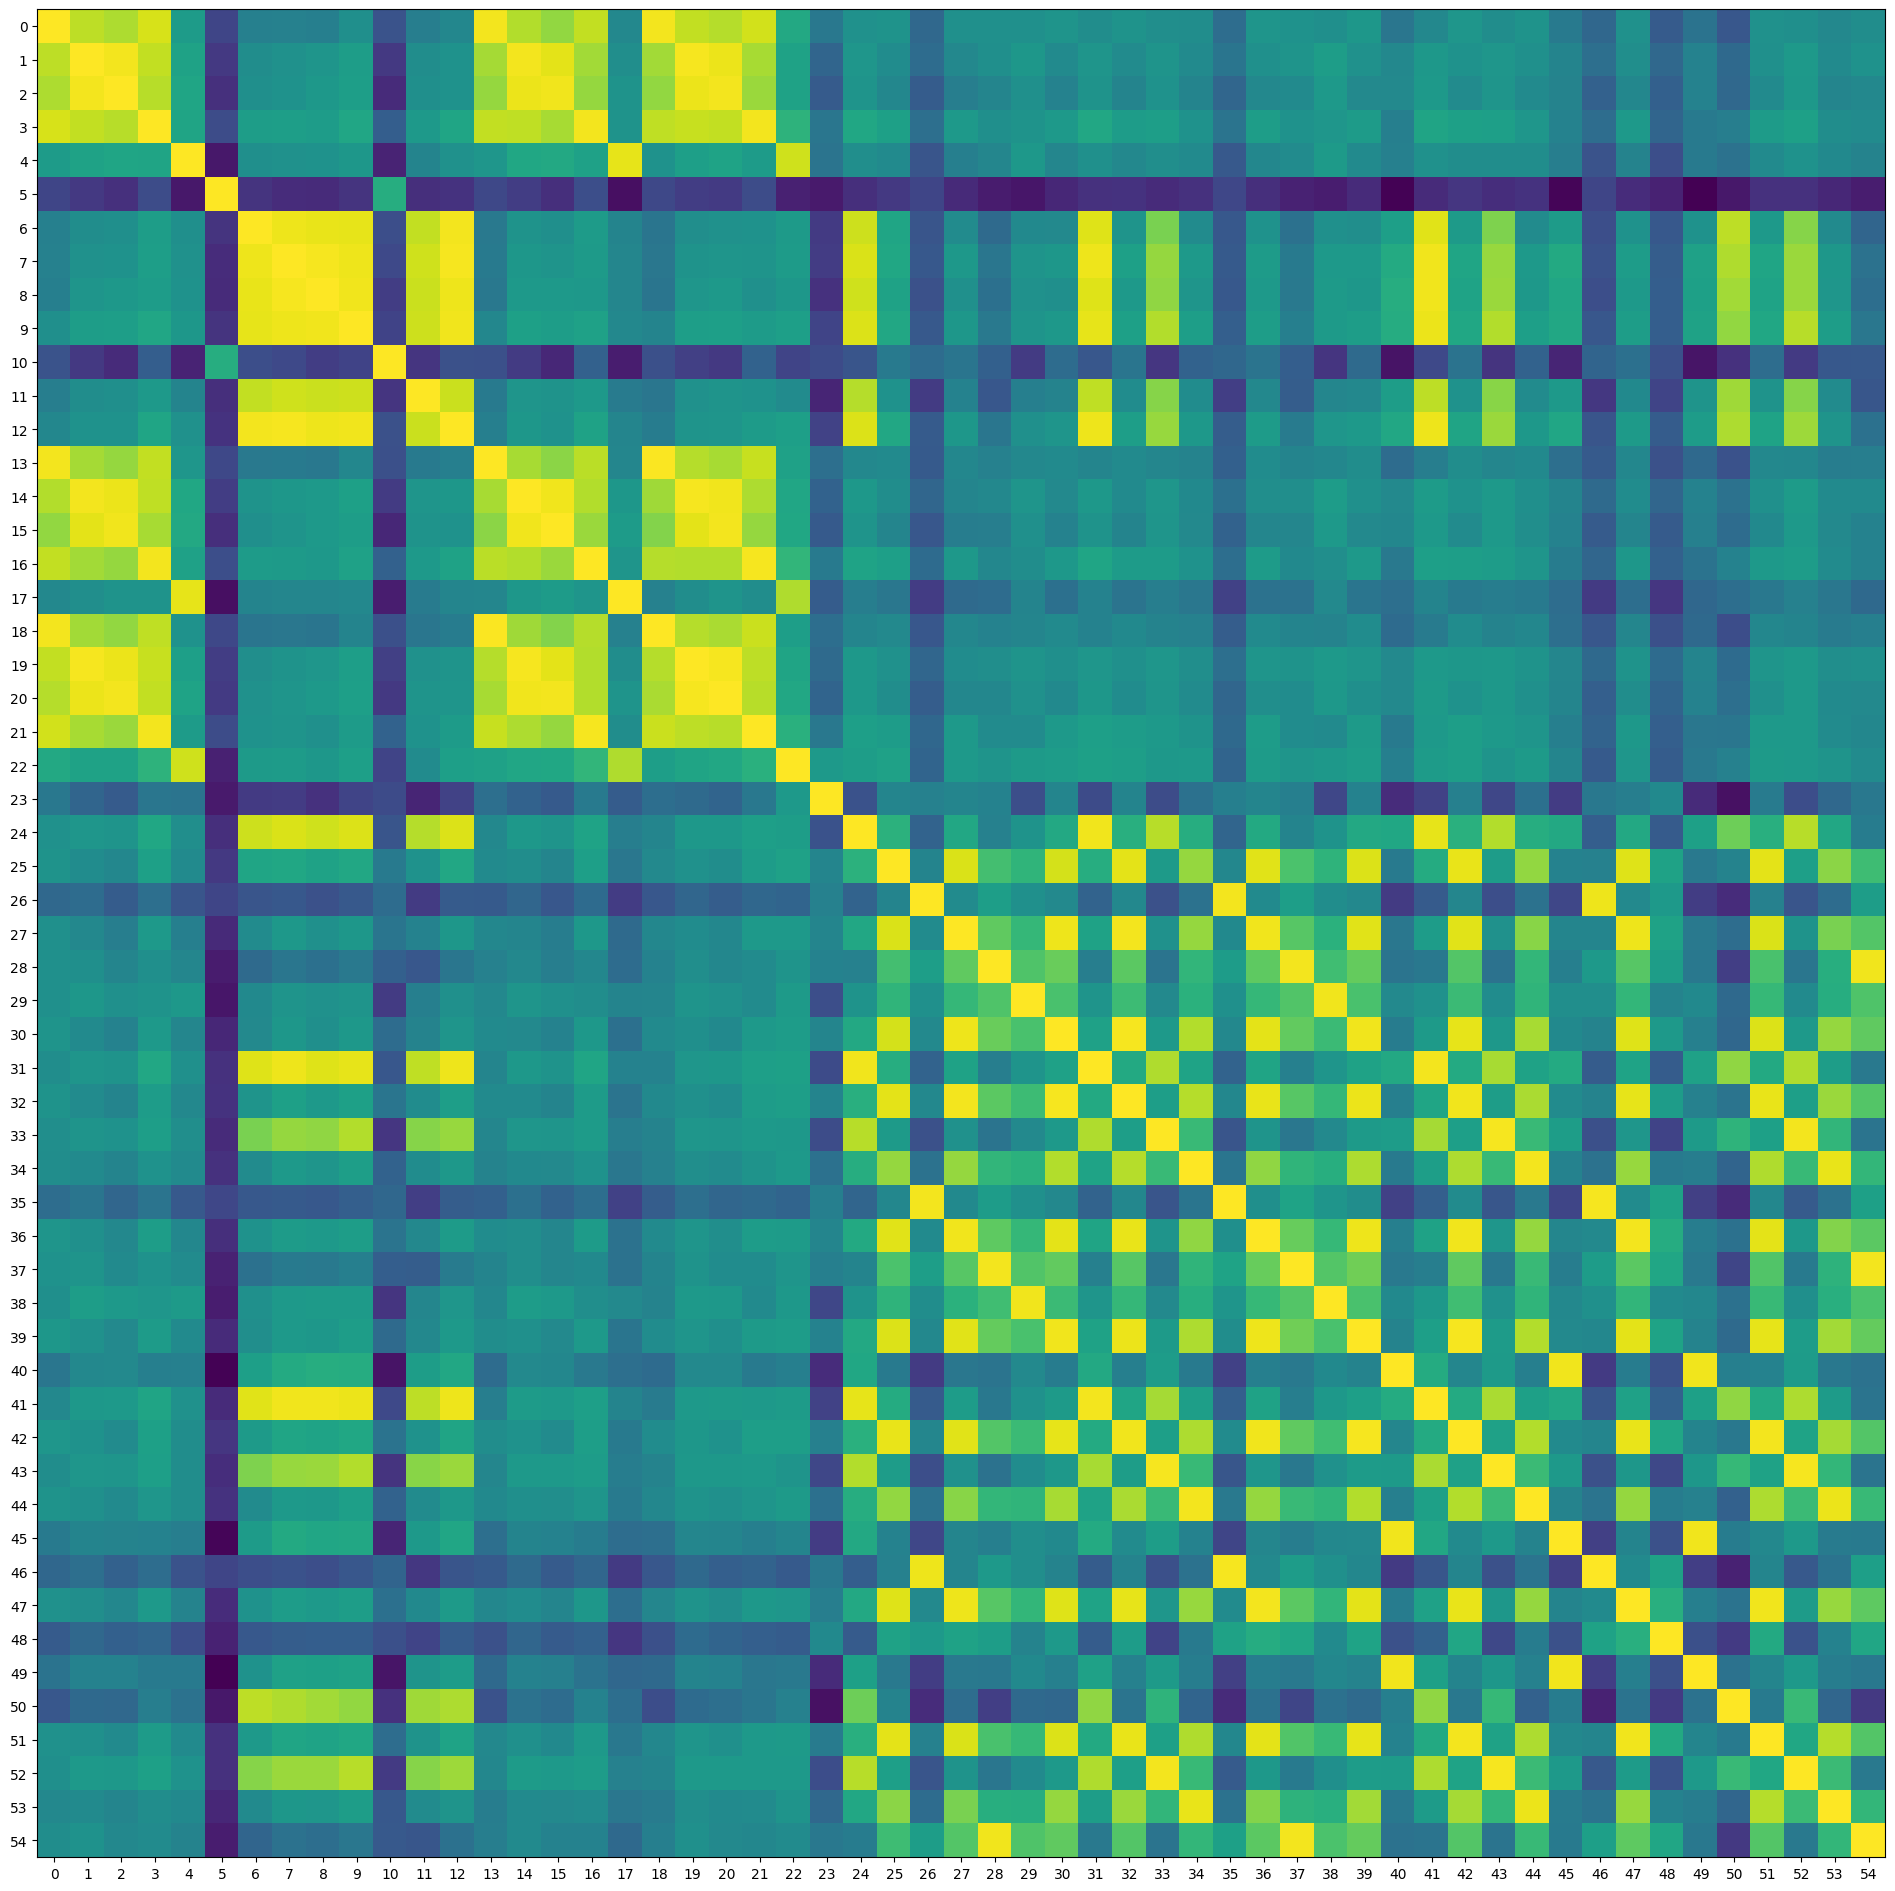

In [20]:
plt.figure(figsize=(24,24))
plt.xticks(range(eq_sim.shape[0]))
plt.yticks(range(eq_sim.shape[0]))
plt.imshow(desc_sim)

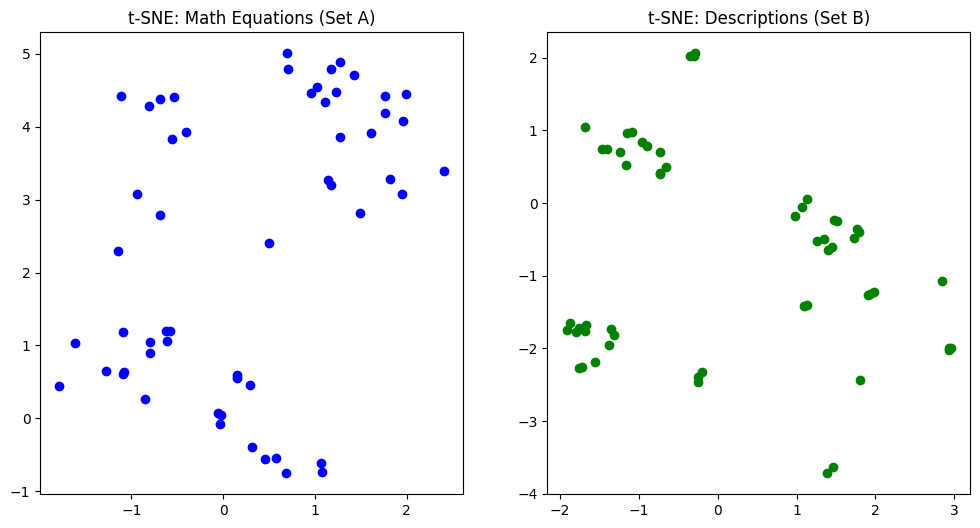

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNE on math equations (Set A)
tsne_A = TSNE(n_components=2, random_state=42, metric="cosine")
tsne_embeddings_A = tsne_A.fit_transform(eq_embs)

# t-SNE on descriptions (Set B)
tsne_B = TSNE(n_components=2, random_state=42, metric="cosine")
tsne_embeddings_B = tsne_B.fit_transform(desc_embs)

# Plot
plt.figure(figsize=(12, 6))

# Plot Set A (math equations)
plt.subplot(1, 2, 1)
plt.scatter(tsne_embeddings_A[:, 0], tsne_embeddings_A[:, 1], color='blue', label='Equations')
plt.title("t-SNE: Math Equations (Set A)")

# Plot Set B (descriptions)
plt.subplot(1, 2, 2)
plt.scatter(tsne_embeddings_B[:, 0], tsne_embeddings_B[:, 1], color='green', label='Descriptions')
plt.title("t-SNE: Descriptions (Set B)")

plt.show()


In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing

from sklearn.neighbors import NearestNeighbors
n_clusters = 5  
kmeans_A = KMeans(n_clusters=n_clusters, random_state=42).fit(preprocessing.normalize(eq_embs))
kmeans_B = KMeans(n_clusters=n_clusters, random_state=42).fit(preprocessing.normalize(desc_embs))

labels_A = kmeans_A.labels_
labels_B = kmeans_B.labels_

ari_score = adjusted_rand_score(labels_A, labels_B)
print(f"Adjusted Rand Index (ARI) between Set A and Set B clusters: {ari_score:.4f}")
nn_model = NearestNeighbors(n_neighbors=1, metric='cosine')
nn_model.fit(desc_embs)
correct_matches = 0
for i, embedding_A in enumerate(eq_embs):
    distance, index = nn_model.kneighbors([embedding_A], return_distance=True)
    if labels_A[i] == labels_B[index[0][0]]:
        correct_matches += 1

accuracy = correct_matches / len(eq_embs)
print(f"Cross-modal cluster matching accuracy: {accuracy * 100:.2f}%")

Adjusted Rand Index (ARI) between Set A and Set B clusters: 0.1776
Cross-modal cluster matching accuracy: 45.45%
